In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

## Temperature

In [2]:
from temperature.utils import get_int_ext_temperature
from temperature.exterior import get_ext_df
import plotly.express as px

In [37]:
date_installation = '2021-07-17 17:00:00'

In [ ]:
# Scripts to pull data 

# df_2020 = get_int_ext_temperature('2020-06-01', '2020-08-31')
# df_2020.to_csv("all_temperature_2020.csv")

# df_2021 = get_int_ext_temperature('2021-06-01', '2021-07-23')
# df_2021.to_csv("all_temperature_2021.csv")

In [27]:
# Read data 

df_2020 = pd.read_csv('data/all_temperature_2020.csv')
df_2021 = pd.read_csv('data/all_temperature_2021.csv')

# Build dataset
df = pd.concat([df_2020[df_2020['datetime'] < '2020-09-01'], df_2021])
df['datetime'] = pd.to_datetime(df['datetime'])

In [28]:
# Add features 

df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
df['install'] = np.where(df['datetime'] > date_installation, 1, 0)

# Remove column
df.drop('Unnamed: 0', axis=1, inplace=True)
df.dropna(inplace=True)

In [57]:
# What is the mean temperature per hour of the day? 

df_hour_pre = df[df['datetime'] < date_installation].groupby('hour')['datetime', 'temp_interior', 'temp_exterior', 'diff'].mean().reset_index()
df_hour_pre['datetime'] = df_hour_pre['hour']
plot_diff_graph(df_hour_pre)
print(df_hour_pre['diff'].mean())

3.4636817254271115


In [58]:
# What is the mean temperature per hour of the day? 

df_hour_post = df[df['datetime'] > date_installation].groupby('hour')['datetime', 'temp_interior', 'temp_exterior', 'diff'].mean().reset_index()
df_hour_post['datetime'] = df_hour_post['hour']
plot_diff_graph(df_hour_post)
print(df_hour_post['diff'].mean())

-0.9561224489795915


In [82]:
# Only take day differences 
df = df[(df['hour'] > 13) & (df['hour'] < 21)]
df[df['month'] == 7]

,datetime,temp_interior,temp_exterior,diff,hour,month,install
734,2020-07-01 14:00:00,28.5,23.2,5.3,14,7,0
735,2020-07-01 15:00:00,28.5,21.4,7.1,15,7,0
736,2020-07-01 16:00:00,29.2,22.6,6.6,16,7,0
737,2020-07-01 17:00:00,29.7,20.0,9.7,17,7,0
738,2020-07-01 18:00:00,29.6,20.8,8.8,18,7,0
...,...,...,...,...,...,...,...
1263,2021-07-23 15:00:00,28.5,28.8,-0.3,15,7,1
1264,2021-07-23 16:00:00,28.8,30.0,-1.2,16,7,1
1265,2021-07-23 17:00:00,28.9,28.9,0.0,17,7,1
1266,2021-07-23 18:00:00,28.8,29.4,-0.6,18,7,1


In [83]:
Y = df['diff']
X = df[['install', 'month', 'hour']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     118.2
Date:                Sun, 25 Jul 2021   Prob (F-statistic):           1.25e-65
Time:                        15:13:16   Log-Likelihood:                -2438.4
No. Observations:                1014   AIC:                             4885.
Df Residuals:                    1010   BIC:                             4905.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.1992      1.040     16.537      0.0

In [8]:
def plot_diff_graph(df):
    """Stack df and plot"""
    df = df[['datetime', 'temp_interior', 'temp_exterior', 'diff']]
    df_stack = df.set_index('datetime')\
                    .stack().reset_index()\
                    .rename(columns={'level_1':'variable',
                                    0:'value'})

    fig = px.line(df_stack, x="datetime", y="value", color="variable")
    return fig.show()

In [35]:
df_dd = df[['datetime', 'temp_interior', 'temp_exterior']]\
    .set_index('datetime')\
    .stack().reset_index()\
    .rename(columns={'level_1':'variable',
                    0:'value'})

In [43]:
df_dd['time'] = np.where(df_dd['datetime'] > date_installation, 1, 0)
df_dd['int'] =  np.where(df_dd['variable'] == 'temp_interior', 1, 0)
df_dd['inter'] = df_dd['time'] * df_dd['int']

In [46]:
X2 = df_dd[['time', 'int', 'inter']]
Y2 = df_dd['value']

In [47]:
X3 = sm.add_constant(X2)
est = sm.OLS(Y2, X3)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     149.1
Date:                Sun, 25 Jul 2021   Prob (F-statistic):           2.63e-87
Time:                        14:10:29   Log-Likelihood:                -5559.9
No. Observations:                2028   AIC:                         1.113e+04
Df Residuals:                    2024   BIC:                         1.115e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.9328      0.121    198.403      0.0

In [73]:
df_2020['datetime'] = pd.to_datetime(df_2020['datetime'])
df_2020[(df_2020['datetime'].dt.month == 7) & 
        (df_2020['datetime'].dt.hour > 12) & 
        (df_2020['datetime'].dt.hour < 20)]['temp_exterior'].mean()

24.65714285714286

In [74]:
df_2021['datetime'] = pd.to_datetime(df_2021['datetime'])
df_2021[(df_2021['datetime'].dt.month == 7) & 
        (df_2021['datetime'].dt.hour > 12) & 
        (df_2021['datetime'].dt.hour < 20)]['temp_exterior'].mean()

23.365838509316767

In [80]:
plot_diff_graph(df_2020)

In [96]:
df['date'] = df['datetime'].dt.date
df['year'] = df['datetime'].dt.year

In [106]:
df_plot_am = df.query("year==2021").groupby('date')['diff'].mean().reset_index()
fig = px.bar(df_plot_am, 
                 x="date", 
                 y="diff", 
                 title="Difference interior exterior temperature at Martin's home")
fig.add_annotation(x=date_installation, y=3,
            text="Install double glass roof",
            showarrow=True,
            arrowhead=0)
fig.show()

In [31]:
px.line(df.query("hour == 18"), x="datetime", y="diff", title="Difference temperature interior - exterior at 6pm")

pull temperature between 1596672000.0 and 1596810417.135362
fetching date 2020-08-06 00:00:00
fetching date 2020-08-07 00:00:00


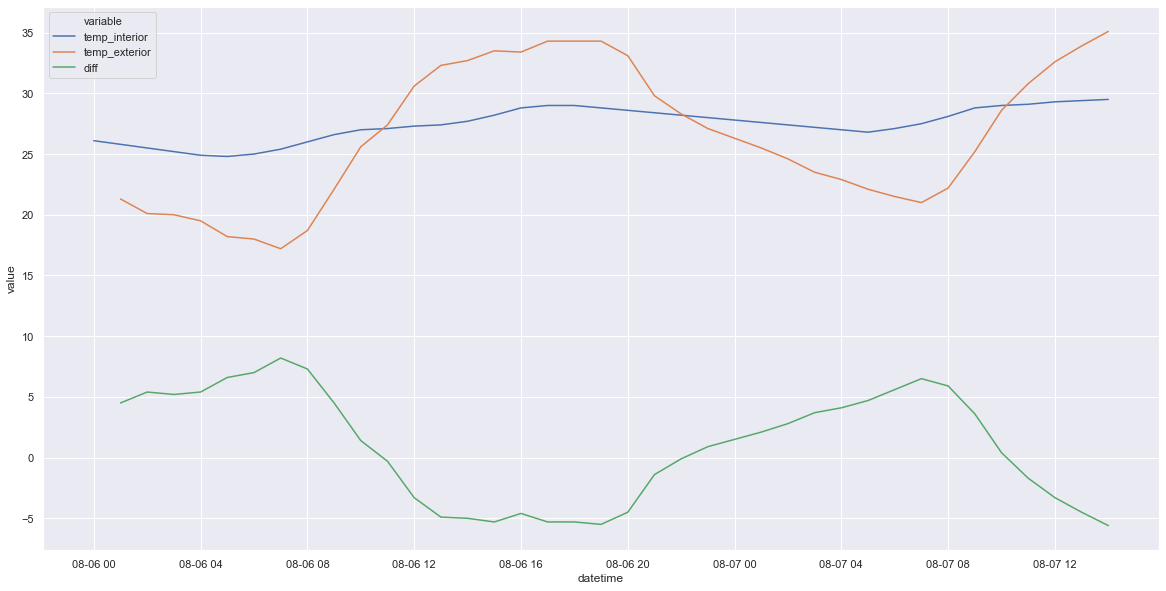

In [2]:
plot_int_ext('2020-08-06', '2020-08-07')

## Gaz

In [3]:
from gaz.gazpar import get_data_per_day

In [4]:
get_data_per_day('30-07-2020', '07-08-2020')

[{'date': '30-07-2020', 'kwh': 2, 'mcube': 0.23},
 {'date': '31-07-2020', 'kwh': 0, 'mcube': 0.0},
 {'date': '01-08-2020', 'kwh': 0, 'mcube': 0.0},
 {'date': '02-08-2020', 'kwh': 1, 'mcube': 0.13},
 {'date': '03-08-2020', 'kwh': 0, 'mcube': 0.0},
 {'date': '04-08-2020', 'kwh': 1, 'mcube': 0.13},
 {'date': '05-08-2020', 'kwh': 0, 'mcube': 0.0}]